In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import make_transition_matrix as right_scheme
import stochastic_matrix_central_scheme_2 as cent_scheme
import sparse_stoch_mat_central as sp_stoch_mat
import sys
import timeit
from scipy.linalg import lu_solve,lu_factor
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import SuperLU
sys.path.append('/home/hcleroy/Extra_Module_py/')
from formated_matplotlib import *

## Equation differential of the problem :
$$ 
\begin{cases}
&\partial_t \rho_a = \partial_x^2 \rho_a +\partial_x[\rho_a \partial_x V_a] + \rho_b k_{ba} + \rho_c k_{ca} - \rho_a(k_{ac}+k_{ab})\\
&\partial_t \rho_b = \partial_x^2 \rho_b +\partial_x[\rho_b \partial_x V_b] + \rho_a k_{ab} + \rho_c k_{cb} - \rho_b(k_{bc}+k_{ba})\\
&\partial_t \rho_c = \partial_x^2 \rho_c +\partial_x[\rho_c \partial_x V_c] + \rho_a k_{ac} + \rho_b k_{bc} - \rho_c(k_{ca}+k_{cb})\\
\end{cases}
$$
with :
$$
\begin{cases}
&k_{ab} = k_{ab}^0 e^{V_a+\epsilon_{ab}}A_{ab} \hspace{1cm} k_{bc} = k_{bc}^0e^{V_b+\epsilon_{bc}}A_{bc} \hspace{1cm} k_{ac} = k_{ac}^0 e^{V_a+\epsilon_{ac}}A_{ac}\\
&k_{ba} = k_{ab}^0 e^{V_b+\epsilon_{ab}} \hspace{1cm} k_{cb} = k_{bc}^0e^{V_c+\epsilon_{bc}} \hspace{1cm} k_{ca} = k_{ac}^0 e^{V_c+\epsilon_{ac}}
\end{cases}
$$
Where $V_a$, $V_b$, and $V_c$ are the space dependent potential that affect respectively $a$, $b$, $c$, $A_{ab}$, $A_{bc}$, $A_{ac}$ are respectively the activity brought to the reaction $a\rightarrow b$, $b\rightarrow c$, $a\rightarrow c$. the $k^0$ will define time units.

In [2]:
V0a, V0b, V0c = 1.,0.,0.#2.,2.6,4.
kab0,kbc0,kac0 = 1.,1.,1.
Aab,Abc,Aac = 1.,1.,1. # != 1 -> ooe
X0,Xf,n = -5,5,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print('dx = '+str(dx))
Eab,Ebc,Eac = 0.1,0.15,0.2
steep = 2.
# define all the Vs :
Va = lambda x : 0.5*(1+np.tanh(steep * x)) * V0a
dVa = lambda x : 0.5*steep/np.cosh(steep*x)**2 * V0a

Vb = lambda x : 0.5*(1+np.tanh(steep*x)) * V0b
dVb = lambda x : 0.5*steep/np.cosh(steep*x)**2 * V0b

Vc = lambda x : 0.5*(1+np.tanh(x*steep)) * V0c
dVc = lambda x : 0.5*steep/np.cosh(x*steep)**2 * V0c

# define all the k's
kab = lambda x,*arg : kab0 * np.exp(Va(x)+Eab)*arg[0] # arg is the activity
kba = lambda x,*arg : kab0 * np.exp(Vb(x)+Eab) # no activity but it takes the same argument as kab

kbc = lambda x,*arg : kbc0 * np.exp(Vb(x)+Ebc)*arg[0] # arg is the activity
kcb = lambda x,*arg : kbc0 * np.exp(Vc(x)+Ebc) # no activity but it takes the same argument as kbc

kac = lambda x,*arg : kac0 * np.exp(Va(x)+Eac)*arg[0] # arg is the activity
kca = lambda x,*arg : kac0 * np.exp(Vc(x)+Eac) # no activity but it takes the same argument as kac

dx = 0.001


## Discrete description of the system

We convert the spacial problem into a matrix problem by writting the derivative as finite difference using central difference scheme :
$$\partial_x\rho|_x = \frac{\rho((i+1)\delta x) - \rho((i-1) \delta x)}{2*\delta x}$$
$$\partial_x^2\rho|_x = \frac{\rho((i+2)\delta x) + \rho((i-2)\delta x) - 2\rho(i \delta x)}{(2*\delta x)^2}$$
We define :
$$\bar{\rho} = \{ \rho_a(x_0), \rho_a(x_0+\delta x), ... , \rho_a(x0 + i\delta x), ... , \rho_a(x_f), \rho_b(x_ 0), ... , \rho_b(x_f), \rho_c(x_0), ... , \rho_c(x_f)\}$$
which contains everything we need to know about the system. We can thus write the time evolution as :
$$\partial_t \bar{\rho} = M \bar{\rho}$$
Looking for the steady state solution, we just have to find the kernel of M. M is a stochastic matrix, thus has only one 0 eigenvalue.


In [3]:
Mat_right = right_scheme.make_transition_matrix(dVa,dVb,dVc,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=1.,Abc=1.,Aac=1.,
                                    X0=X0,Xf=Xf,n=n)

In [4]:
Mat_cent = sp_stoch_mat.make_transition_matrix(Va,Vb,Vc,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=1.,Abc=1.,Aac=1.,
                                    X0=X0,Xf=Xf,n=n)

In [5]:
Mat_cent = cent_scheme.make_transition_matrix(Va,Vb,Vc,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=1.,Abc=1.,Aac=1.,
                                    X0=X0,Xf=Xf,n=n)

/home/hcleroy/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


KeyboardInterrupt: 

In [7]:
print(sys.getsizeof(Mat_right))
print(sys.getsizeof(Mat_cent))

7200000128
48


Text(0, 0.5, 'sum of the transition')

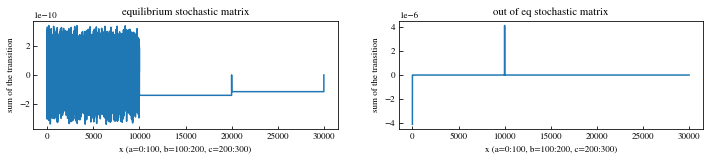

In [5]:
# check that the sum over the axis 0 is 0, because we have to have a stochastic matrix
fig,ax = plt.subplots(figsize = (12,2), ncols=2)
ax[0].plot(np.sum(Mat_right,axis=0))
ax[0].set_xlabel('x (a=0:100, b=100:200, c=200:300)')
ax[0].set_ylabel('sum of the transition')
ax[0].set_title('equilibrium stochastic matrix')
ax[1].plot(np.sum(Mat_cent,axis=0).A[0])
ax[1].set_title('out of eq stochastic matrix')
ax[1].set_xlabel('x (a=0:100, b=100:200, c=200:300)')
ax[1].set_ylabel('sum of the transition')

# Compare the resolution mechanism
## Using the diagonalization

start = timeit.default_timer()
v_cent,w_cent = la.eig(Mat_cent)
print('time :' ,timeit.default_timer()-start)
for i in range(v_cent.shape[0]):
    w_cent[:,i] = abs(w_cent[:,i])/(sum(abs(w_cent[:,i]))*dx)
rho_a_cent = np.real(w_cent[:,np.argsort(v_cent)[-1]][:n])
rho_b_cent = np.real(w_cent[:,np.argsort(v_cent)[-1]][n:2*n])
rho_c_cent = np.real(w_cent[:,np.argsort(v_cent)[-1]][2*n:3*n])
v,w = la.eig(Mat_right)
for i in range(v.shape[0]):
    w[:,i] = abs(w[:,i])/(sum(abs(w[:,i]))*dx)
rho_a_right = np.real(w[:,np.argsort(v)[-1]][:n])
rho_b_right = np.real(w[:,np.argsort(v)[-1]][n:2*n])
rho_c_right = np.real(w[:,np.argsort(v)[-1]][2*n:3*n])

## Using LU

In [7]:
Omega1 = Mat_cent[1:,1:]
B = Mat_cent[1:,0]
start = timeit.default_timer()
x = spsolve(Omega1,-B)
#SLU = SuperLU(Omega1)
#x = SLU.solve(-B)
#x = lu_solve(lu_factor(Omega1),-B)
#x = np.linalg.lstsq(Omega1,-B)[0]
print('time :' ,timeit.default_timer()-start)
rho_lu = np.zeros(x.shape[0]+1,dtype=float)
rho_lu[0] = 1
rho_lu [1:] = x
rho_lu = abs(rho_lu)/(sum(abs(rho_lu))*dx)
rho_a_cent = np.real(rho_lu[:n])
rho_b_cent = np.real(rho_lu[n:2*n])
rho_c_cent = np.real(rho_lu[2*n:])

time : 8.40192352799977


In [8]:
Omega1 = Mat_right[1:,1:]
B = Mat_right[1:,0]
start = timeit.default_timer()
x = lu_solve(lu_factor(Omega1),-B)
#x = np.linalg.lstsq(Omega1,-B)[0]
print('time :' ,timeit.default_timer()-start)
rho_lu = np.zeros(x.shape[0]+1,dtype=float)
rho_lu[0] = 1
rho_lu [1:] = x
rho_lu = abs(rho_lu)/(sum(abs(rho_lu))*dx)
rho_a_right = np.real(rho_lu[:n])
rho_b_right = np.real(rho_lu[n:2*n])
rho_c_right = np.real(rho_lu[2*n:])

time : 114.41164875100003


In [9]:
print("central scheme probability normalisation : "+str(sum(rho_a_cent)*dx+sum(rho_b_cent)*dx+sum(rho_c_cent)*dx))
print("right scheme probability normalisation : "+str(sum(rho_a_right)*dx+sum(rho_b_right)*dx+sum(rho_c_right)*dx))

central scheme probability normalisation : 1.0000000000000093
right scheme probability normalisation : 1.0000000000000049


We check the compatibility between the equilibrium solution (from the matrix) and the one given by equilibrium statistical mechanics. Equilibrium stat-mech gives :
$$
\begin{aligned}
&P_a^\text{eq}(x) = \frac{e^{V_a(x)}}{Z} \\
&P_b^\text{eq}(x) = \frac{e^{V_b(x)}}{Z} \\
&P_c^\text{eq}(x) = \frac{e^{V_c(x)}}{Z} \\
\end{aligned}
$$
with $Z$ given by the normalisation condition :
$$
Z = \int_{X0}^{Xf}P_a^\text{eq}(x)+P_b^\text{eq}(x)+P_c^\text{eq}(x) \text{d}x
$$

In [10]:
def make_eq_distrib(Va,Vb,Vc,x):
    rho_a,rho_b,rho_c = np.exp(-Va(x)),np.exp(-Vb(x)),np.exp(-Vc(x))
    Z = (sum(rho_a)+sum(rho_b)+sum(rho_c))*dx
    res = np.zeros(3*n,dtype=float)
    return rho_a/Z,rho_b/Z,rho_c/Z
def percent_diff(array1,array2):
    return (array1-array2)/(array1+array2)*100

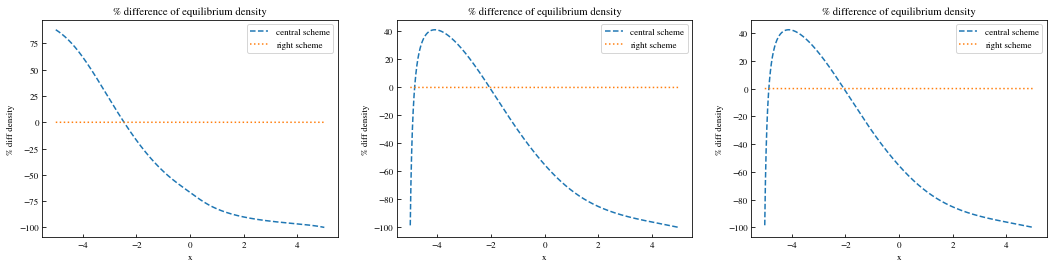

In [11]:
rho_a_stat_mech, rho_b_stat_mech,rho_c_stat_mech = make_eq_distrib(Va,Vb,Vc,np.linspace(X0,Xf,n,endpoint=False))


fig,ax = plt.subplots(figsize=(18,4),ncols=3)
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),percent_diff(rho_a_cent,rho_a_stat_mech),linestyle='--',label='central scheme')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),percent_diff(rho_a_right,rho_a_stat_mech),linestyle=':',label='right scheme')
#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),rho_a_stat_mech,label='stat mech')

ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),percent_diff(rho_b_cent,rho_b_stat_mech),linestyle='--',label='central scheme')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),percent_diff(rho_b_right,rho_b_stat_mech),linestyle=':',label='right scheme')

ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),percent_diff(rho_c_cent,rho_c_stat_mech),linestyle='--',label='central scheme')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),percent_diff(rho_c_right,rho_c_stat_mech),linestyle=':',label='right scheme')


ax[0].set_title('% difference of equilibrium density')
ax[0].set_xlabel('x')
ax[0].set_ylabel('% diff density')
ax[0].legend()

ax[1].set_title('% difference of equilibrium density')
ax[1].set_xlabel('x')
ax[1].set_ylabel('% diff density')
ax[1].legend()

ax[2].set_title('% difference of equilibrium density')
ax[2].set_xlabel('x')
ax[2].set_ylabel('% diff density')
ax[2].legend()
#ax1 = ax[0].twinx()
#ax1.plot(np.linspace(X0,Xf,n,endpoint=False),Va(np.linspace(X0,Xf,n,endpoint=False)),c='black')
#ax1.set_ylabel('Va')

## Computation of the fluxs

The chemical flux of each specie is defined as :
$$
\phi_i^\chi(x) = \sum_{j \neq i} k_{ji}(x)\rho_j(x) - \sum_{j\neq i}k_{ij}(x) \rho_i(x)
$$
On the other hand the diffusive flux gives:
$$
\phi_i^\text{diff}(x) = \partial_x^2 \rho_i +\partial_x[\rho_i \partial_x V_i]
$$
For each species we represent these fluxes as a vectorial field in the 2d plan where X is the space and Y is A/B.

In [30]:
# define the two fluxes :
def chem_flux(kjis,kijs,rho_i,rho_js,ix,x):
    """
    - kjis : is a vector of chemical transition from any j to the specie i
    - kijs : is a vector of chemical transition from the specie i to any j
    - rho_i : is the array of density in space of the specie i
    - rho_js : is the array of array of density in space of all the j's species
    - x : is the position in space
    - ix : is the corresponding index
    !!!!! the kjis, kijs, and rho_js must be sorted similarly
    """
    if rho_js.shape[0] != kjis.shape[0] or rho_js.shape[0] != kjis.shape[0] :
        raise IndexError
    return sum([kjis[j](x)*rho_js[j][ix]-kijs[j](x)*rho_i[ix] for j in range(rho_js.__len__())])
def diff_flux(rho,V,ix,x):
    """"
    - rho_i : is the vector of density in space
    - dV : is a function dV(x) returns the derivative of the potential in x
    - x.dx is the position in space
    """
    if ix <= 1:
        return 0
    elif ix>=rho.shape[0]-2:
        return 0.
    else :
        dVxdx = (V(x+2*dx)-V(x))/(2*dx)
        dVxmdx = (V(x)-V(x-2*dx))/(2*dx)
        return (rho[ix+2]+rho[ix-2]-2*rho[ix])/(2*dx)**2 + (rho[ix+1]*dVxdx - rho[ix-1]*dVxmdx)/(2*dx)
        #return (rho[ix+1]+rho[ix-1]-2*rho[ix])/dx**2 + (rho[ix+1]*dVxdx - rho[ix]*dVx)/dx
        #return (rho[ix+1]+rho[ix-1]-2*rho[ix])/dx**2 + (rho[ix+1]*dV(x+dx) - rho[ix]*dV(x))/dx
        #return (rho[ix+2]+rho[ix]-2*rho[ix+1])/dx**2 + (rho[ix+1]*dVxdx - rho[ix]*dVx)/dx

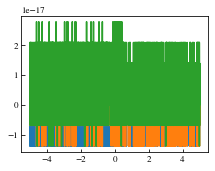

In [31]:
# verify that the stat mech solution leads to detailed balance
ab_flux = rho_a_stat_mech*np.array([kab(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_b_stat_mech*np.array([kba(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
ac_flux = rho_a_stat_mech*np.array([kac(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_c_stat_mech*np.array([kca(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
a_flux = np.array([chem_flux(np.array([kba,kca]),np.array([lambda x:kab(x,1.),lambda x:kac(x,1.)]),rho_a_stat_mech,np.array([rho_b_stat_mech,rho_c_stat_mech]),i,i*dx+X0) for i in range(n)])
plt.plot(np.linspace(X0,Xf,n,endpoint=False),ab_flux)
plt.plot(np.linspace(X0,Xf,n,endpoint=False),ac_flux)
plt.plot(np.linspace(X0,Xf,n,endpoint=False),a_flux)

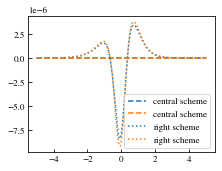

In [32]:
# verify that the stat mech solution leads to detailed balance
ab_flux_cent = rho_a_cent*np.array([kab(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_b_cent*np.array([kba(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
ac_flux_cent = rho_a_cent*np.array([kac(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_c_cent*np.array([kca(x) for x in np.linspace(X0,Xf,n,endpoint=False)])

ab_flux_right = rho_a_right*np.array([kab(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_b_right*np.array([kba(x) for x in np.linspace(X0,Xf,n,endpoint=False)])
ac_flux_right = rho_a_right*np.array([kac(x,1.) for x in np.linspace(X0,Xf,n,endpoint=False)])-rho_c_right*np.array([kca(x) for x in np.linspace(X0,Xf,n,endpoint=False)])

plt.plot(np.linspace(X0,Xf,n,endpoint=False),ab_flux_cent,linestyle='--',color=ColorCycle[0],label='central scheme')
plt.plot(np.linspace(X0,Xf,n,endpoint=False),ac_flux_cent,linestyle='--',color=ColorCycle[1],label='central scheme')

plt.plot(np.linspace(X0,Xf,n,endpoint=False),ab_flux_right,linestyle=':',color=ColorCycle[0],label='right scheme')
plt.plot(np.linspace(X0,Xf,n,endpoint=False),ac_flux_right,linestyle=':',color=ColorCycle[1],label='right scheme')
plt.legend()

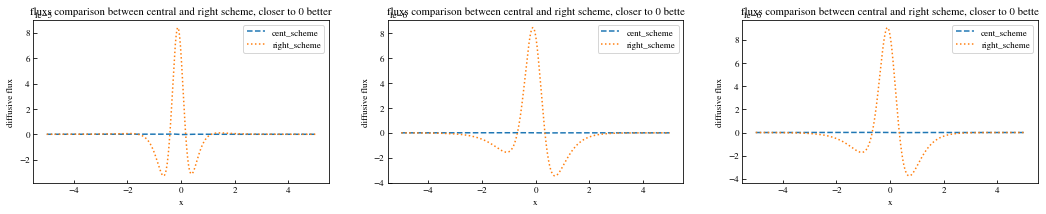

In [33]:
fig,ax = plt.subplots(figsize=(18,3),ncols=3)
#
#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),np.array([diff_flux(rho_b_eq,dVb,i,X0+i*dx)for i in range(n)]),linestyle='--',color=ColorCycle[1])
#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),np.array([diff_flux(rho_c_eq,dVc,i,X0+i*dx) for i in range(n)]),linestyle='--',color=ColorCycle[2])

ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),
            np.array([diff_flux(rho_a_cent,Va,i,X0+i*dx)for i in range(n)]),
            linestyle='--',color=ColorCycle[0],label='cent_scheme')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),
            np.array([diff_flux(rho_a_right,Va,i,X0+i*dx)for i in range(n)]),
            linestyle=':',color=ColorCycle[1],label='right_scheme')


ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),
            np.array([diff_flux(rho_b_cent,Vb,i,X0+i*dx)for i in range(n)]),
            linestyle='--',color=ColorCycle[0],label='cent_scheme')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),
            np.array([diff_flux(rho_b_right,Vb,i,X0+i*dx)for i in range(n)]),
            linestyle=':',color=ColorCycle[1],label='right_scheme')

ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),
            np.array([diff_flux(rho_c_cent,Vc,i,X0+i*dx)for i in range(n)]),
            linestyle='--',color=ColorCycle[0],label='cent_scheme')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),
            np.array([diff_flux(rho_c_right,Vc,i,X0+i*dx)for i in range(n)]),
            linestyle=':',color=ColorCycle[1],label='right_scheme')

#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),np.array([diff_flux(rho_b_stat_mech,dVb,i,X0+i*dx)for i in range(n)]),color=ColorCycle[1])
#ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),np.array([diff_flux(rho_c_stat_mech,dVc,i,X0+i*dx) for i in range(n)]),color=ColorCycle[2])

ax[0].set_xlabel('x')
ax[0].set_ylabel('diffusive flux')
ax[0].set_title('fluxs comparison between central and right scheme, closer to 0 better')

ax[1].set_xlabel('x')
ax[1].set_ylabel('diffusive flux')
ax[1].set_title('fluxs comparison between central and right scheme, closer to 0 bette')

ax[2].set_xlabel('x')
ax[2].set_ylabel('diffusive flux')
ax[2].set_title('fluxs comparison between central and right scheme, closer to 0 bette')

ax[0].legend()
ax[1].legend()
ax[2].legend()


In [34]:
#ab, ac ,bc 
kajs_eq = np.array([lambda x : kab(x,1.),lambda x : kac(x,1.)])
kjas_eq = np.array([kba,kca])

kbjs_eq = np.array([kba,lambda x : kbc(x,1.)])
kjbs_eq = np.array([lambda x : kab(x,1.),kcb])

kcjs_eq = np.array([kca,kcb])
kjcs_eq = np.array([lambda x : kac(x,1.),lambda x : kbc(x,1.)])

kajs_ooe = np.array([lambda x : kab(x,1.2),lambda x : kac(x,1.)])
kjas_ooe = np.array([kba,kca])

kbjs_ooe = np.array([kba,lambda x : kbc(x,1.)])
kjbs_ooe = np.array([lambda x : kab(x,1.2),kcb])

kcjs_ooe = np.array([kca,kcb])
kjcs_ooe = np.array([lambda x : kac(x,1.),lambda x : kbc(x,1.)])

rho_a_js_right = np.array([rho_b_right,rho_c_right])
rho_b_js_right = np.array([rho_a_right,rho_c_right])
rho_c_js_right = np.array([rho_a_right,rho_b_right])

rho_a_js_stat_mech = np.array([rho_b_stat_mech,rho_c_stat_mech])
rho_b_js_stat_mech = np.array([rho_a_stat_mech,rho_c_stat_mech])
rho_c_js_stat_mech = np.array([rho_a_stat_mech,rho_b_stat_mech])


rho_a_js_cent = np.array([rho_b_cent,rho_c_cent])
rho_b_js_cent = np.array([rho_a_cent,rho_c_cent])
rho_c_js_cent = np.array([rho_a_cent,rho_b_cent])

A_Chem_flux_right = np.array([chem_flux(kjas_eq,kajs_eq,rho_a_right,rho_a_js_right,i,X0+i*dx) for i in range(n)])
B_Chem_flux_right = np.array([chem_flux(kjbs_eq,kbjs_eq,rho_b_right,rho_b_js_right,i,X0+i*dx) for i in range(n)])
C_Chem_flux_right = np.array([chem_flux(kjcs_eq,kcjs_eq,rho_c_right,rho_c_js_right,i,X0+i*dx) for i in range(n)])

A_Chem_flux_stat_mech = np.array([chem_flux(kjas_eq,kajs_eq,rho_a_stat_mech,rho_a_js_stat_mech,i,X0+i*dx) for i in range(n)])
B_Chem_flux_stat_mech = np.array([chem_flux(kjbs_eq,kbjs_eq,rho_b_stat_mech,rho_b_js_stat_mech,i,X0+i*dx) for i in range(n)])
C_Chem_flux_stat_mech = np.array([chem_flux(kjcs_eq,kcjs_eq,rho_c_stat_mech,rho_c_js_stat_mech,i,X0+i*dx) for i in range(n)])

A_Chem_flux_cent = np.array([chem_flux(kjas_eq,kajs_eq,rho_a_cent,rho_a_js_cent,i,X0+i*dx) for i in range(n)])
B_Chem_flux_cent = np.array([chem_flux(kjbs_eq,kbjs_eq,rho_b_cent,rho_b_js_cent,i,X0+i*dx) for i in range(n)])
C_Chem_flux_cent = np.array([chem_flux(kjcs_eq,kcjs_eq,rho_c_cent,rho_c_js_cent,i,X0+i*dx) for i in range(n)])

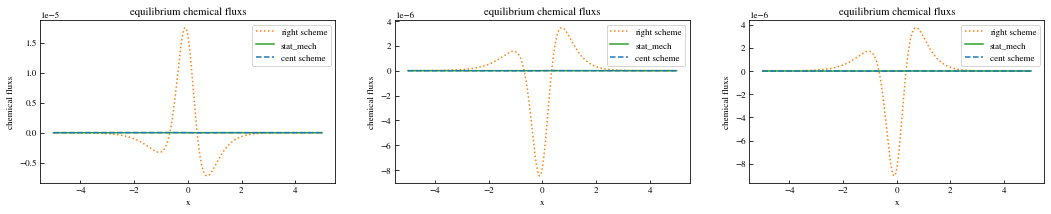

In [35]:
fig,ax = plt.subplots(figsize=(18,3),ncols=3)
# kjis,kijs,rho_i,rho_js,x,dx
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),A_Chem_flux_right,linestyle=':',color=ColorCycle[1],label='right scheme')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),A_Chem_flux_stat_mech,color=ColorCycle[2],label='stat_mech')
ax[0].plot(np.linspace(X0,Xf,n,endpoint=False),A_Chem_flux_cent,linestyle='--',color=ColorCycle[0],label='cent scheme')

ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),B_Chem_flux_right,linestyle=':',color=ColorCycle[1],label='right scheme')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),B_Chem_flux_stat_mech,color=ColorCycle[2],label='stat_mech')
ax[1].plot(np.linspace(X0,Xf,n,endpoint=False),B_Chem_flux_cent,linestyle='--',color=ColorCycle[0],label='cent scheme')

ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),C_Chem_flux_right,linestyle=':',color=ColorCycle[1],label='right scheme')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),C_Chem_flux_stat_mech,color=ColorCycle[2],label='stat_mech')
ax[2].plot(np.linspace(X0,Xf,n,endpoint=False),C_Chem_flux_cent,linestyle='--',color=ColorCycle[0],label='cent scheme')



ax[0].set_xlabel('x')
ax[0].set_ylabel('chemical fluxs')
ax[0].set_title('equilibrium chemical fluxs')
ax[0].legend()

ax[1].set_xlabel('x')
ax[1].set_ylabel('chemical fluxs')
ax[1].set_title('equilibrium chemical fluxs')
ax[1].legend()

ax[2].set_xlabel('x')
ax[2].set_ylabel('chemical fluxs')
ax[2].set_title('equilibrium chemical fluxs')
ax[2].legend()